Algoritm de corectie a culorilor unei imagini, bazat pe PCA.

In primul rand, importam bibliotecile necesare.

cv2 - OpenCV, folosit pentru manipularea imaginilor la nivel de pixel si dimensiune.

matplotlib - Il vom folosi pentru desenarea paletei de culori.

seaborn - Pentru trasarea heatmapului pixelilor schimbati

In [1]:
import numpy as np # numpy
import cv2 # opecv, pentru lucrul cu imagini
import matplotlib.pyplot as plt # matplotlib, pentru plotari
from matplotlib.patches import Patch # pentru legenda
import seaborn as sns # seaborn, pentru heatmap

Functia pentru generarea factorilor de rescalare:

In [2]:
def generate_scaling_factors(image):
    # Imaginea este mapata ca un vector bidimensional,
    # unde fiecare linie reprezinta un pixel, iar coloanele, valorile R, G si B ale pixelului
    pixels = image.reshape((-1, 3)).astype(float)

    # Standardizam pixelii, impartind (pixel - medie)/dispersie
    mean_vector = np.mean(pixels, axis=0)
    std_vector = np.std(pixels, axis=0)
    standardized_pixels = (pixels - mean_vector) / std_vector

    # Calculam matricea de covarianta
    covariance_matrix = np.cov(standardized_pixels, rowvar=False)
    print("Matricea de covarianta:\n", covariance_matrix)

    # Calculam valorile proprii si vectorii proprii ai matricei de covarianta
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Valorile proprii sunt sortate descrescator,
    # iar vectorii proprii sunt rearanjati pentru a corespunde ordinii valorilor proprii
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    print("\n \nValorile proprii sortate:\n", eigenvalues)
    print("Vectorii proprii sortati:\n", eigenvectors)

    # Selectam primele cele 3 valori principale - primii 3 vectori proprii
    principal_components = eigenvectors[:, :3]

    # Fiecare rand din matricea de pixeli standardizati este inmultit cu matricea de componente principale,
    # si schimbam modul in care pixelii sunt reprezentati in spatiu in functie de cele 3 componente principale
    transformed_pixels = standardized_pixels.dot(principal_components)

    # Calculam factorii de scalare
    scaling_factors = np.std(transformed_pixels, axis=0) / np.mean(np.abs(transformed_pixels), axis=0)

    print("\n \nDeviatia standard a pixelilor scalati:", np.std(transformed_pixels, axis=0))
    print("Media absoluta a pixelilor scalati:   ", np.mean(np.abs(transformed_pixels), axis=0))
    print(" => Factorii de scalare:              ", scaling_factors)

    return scaling_factors

Functia propriu-zisa de corectie a culorilor:

In [3]:
def color_correction(image):
    # Transformam imaginea intr-un vector bidimensional, unde fiecare linie reprezinta un pixel,
    # iar coloanele, valorile R, G si B ale pixelului ca float - la fel ca in generate_scaling_factors
    pixels = image.reshape((-1, 3)).astype(float)
    
    # Calculam media pixelilor de fiecare culoare - R, G, B
    mean_vector = np.mean(pixels, axis=0)

    # Calculam dispersia fata de mediile din mean_vector
    std_vector = np.std(pixels, axis=0)

    # Standardizam pixelii: (pixel - media) / dispersie
    standardized_pixels = (pixels - mean_vector) / std_vector

    # Calculam matricea de covarianta
    covariance_matrix = np.cov(standardized_pixels, rowvar=False)

    # Calculam vectorii proprii si valorile proprii ale matricei de covarianta
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Valorile proprii sunt sortate descrescator,
    # iar vectorii proprii sunt rearanjati pentru a corespunde ordinii valorilor proprii
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Componentele principale sunt primii 3 vectori proprii
    principal_components = eigenvectors[:, :3]

    # Proiectam pixelii standardizati dupa componentele principale
    projected_pixels = np.dot(standardized_pixels, principal_components)

    # Ne luam factorii de scalare
    scaling_factors = generate_scaling_factors(image)

    # Corectam pixelii proiectati, inmultindu-i cu factorii de scalare
    corrected_pixels = projected_pixels * scaling_factors

    # Ne intoarcem la spatul original de pixeli, inmultind cu transpusa componentelor principale
    corrected_pixels = np.dot(corrected_pixels, principal_components.T)
    
    # De-standardizam pixelii, inmultind cu dispersia si adunand media
    corrected_pixels = corrected_pixels * std_vector + mean_vector

    # Transformam vectorul de pixeli inapoi in imagine
    corrected_image = corrected_pixels.reshape(image.shape)

    # Si ne asiguram ca suntem in spatiul 8-bit de culoare, cu valori 0 - 255
    return np.clip(corrected_image, 0, 255).astype(np.uint8)

Generam heatmapul ce ne arata diferenta:

In [4]:
def plot_difference_heatmap(original_image, corrected_image):
    # Calculam diferenta dintre imaginea originala si cea corectata
    diff_image = np.abs(original_image - corrected_image)

    # Calculam norma 2 a diferentelor pe fiecare pixel
    RGB_scope_difference = np.linalg.norm(diff_image, axis=2)

    # Si afisam rezultatul sub forma de heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(RGB_scope_difference, cmap='coolwarm')
    plt.title('Pixel-wise Difference Heatmap')
    plt.show()

Generam histogramele pentru fiecare canal de culoare:

In [5]:
def component_histograms(original_image, image_title):
    channels = cv2.split(original_image)

    colors = ("b", "g", "r")
    plt.figure(figsize=(10, 10))
    plt.title(image_title + " separate scopes histograms")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")

    # For each channel: calculate histogram, plot it, calculate median, plot vertical line
    for (channel, color) in zip(channels, colors):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        plt.plot(hist, color=color)
        median = np.median(channel)
        plt.axvline(median, color=color, linestyle='dashed', linewidth=2)

    plt.legend(['Blue', 'Green', 'Red', 'Median Blue', 'Median Green', 'Median Red'])
    plt.show()

Generam histogramele celor doua imagini pentru a vedea cum este afectata fiecare zona:

In [6]:
def histograms(original_image, corrected_image):
    hist_original = cv2.calcHist([original_image], [0], None, [256], [0, 256])
    hist_corrected = cv2.calcHist([corrected_image], [0], None, [256], [0, 256])

    plt.figure(figsize=(10, 10))
    plt.title("Histograms")
    plt.xlabel("8 bit color values")
    plt.ylabel("# of Pixels")
    plt.plot(hist_original, color='orange', label="Original")
    plt.plot(hist_corrected, color='blue', label="Corrected")

    # Create a color legend
    legend_elements = [Patch(facecolor='orange', edgecolor='orange', label='Original'),
                       Patch(facecolor='blue', edgecolor='blue', label='Corrected')]

    plt.legend(handles=legend_elements)
    plt.show()

Ne testam functiile:

Matricea de covarianta:
 [[1.00000381 0.91065065 0.67636569]
 [0.91065065 1.00000381 0.8786374 ]
 [0.67636569 0.8786374  1.00000381]]

 
Valorile proprii sortate:
 [2.6479033  0.32464507 0.02746307]
Vectorii proprii sortati:
 [[-0.56502038 -0.67641131  0.47246132]
 [-0.60902613 -0.04440047 -0.79190642]
 [-0.55663197  0.73518456  0.38686499]]

 
Deviatia standard a pixelilor scalati: [1.62723483 0.56977525 0.16571954]
Media absoluta a pixelilor scalati:    [1.34321336 0.47627088 0.12717897]
 => Factorii de scalare:               [1.21144926 1.19632603 1.30304198]


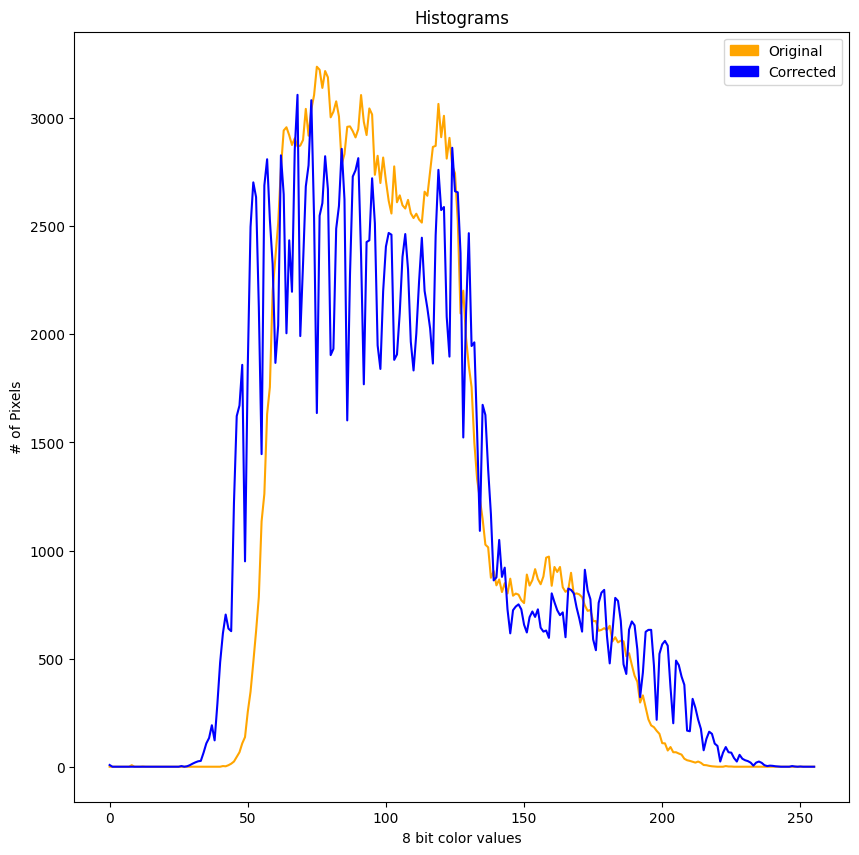

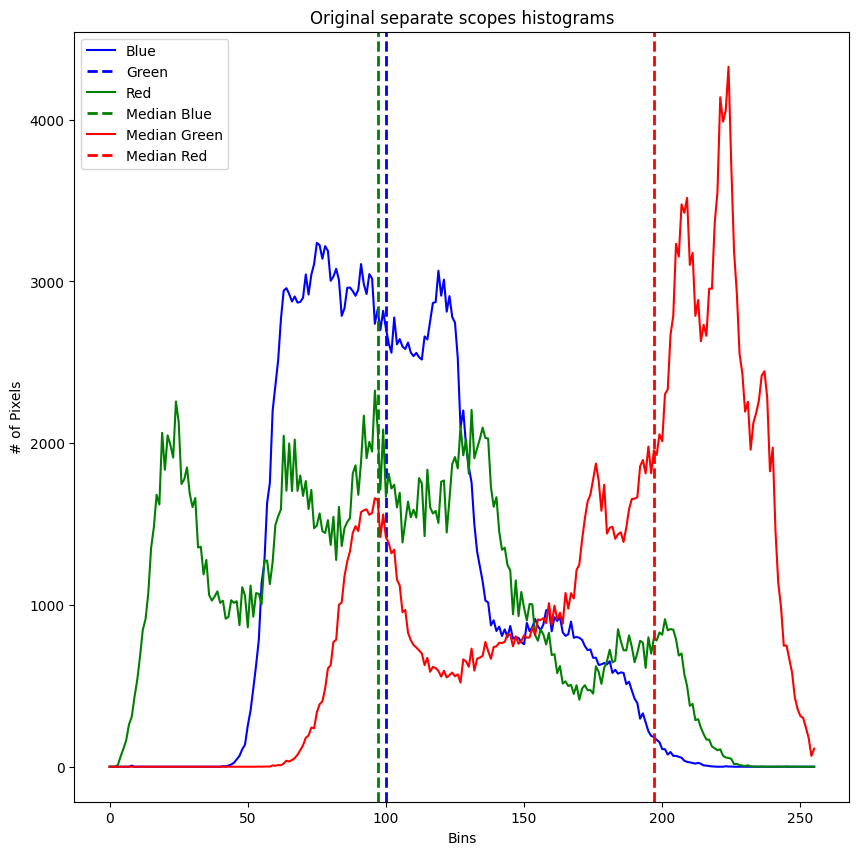

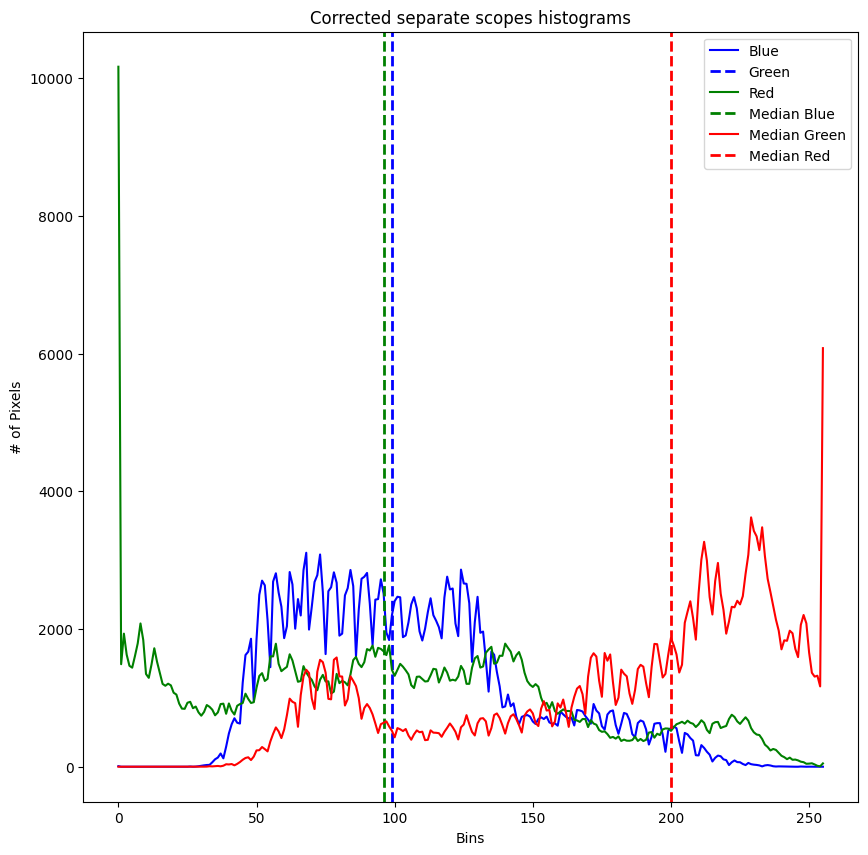

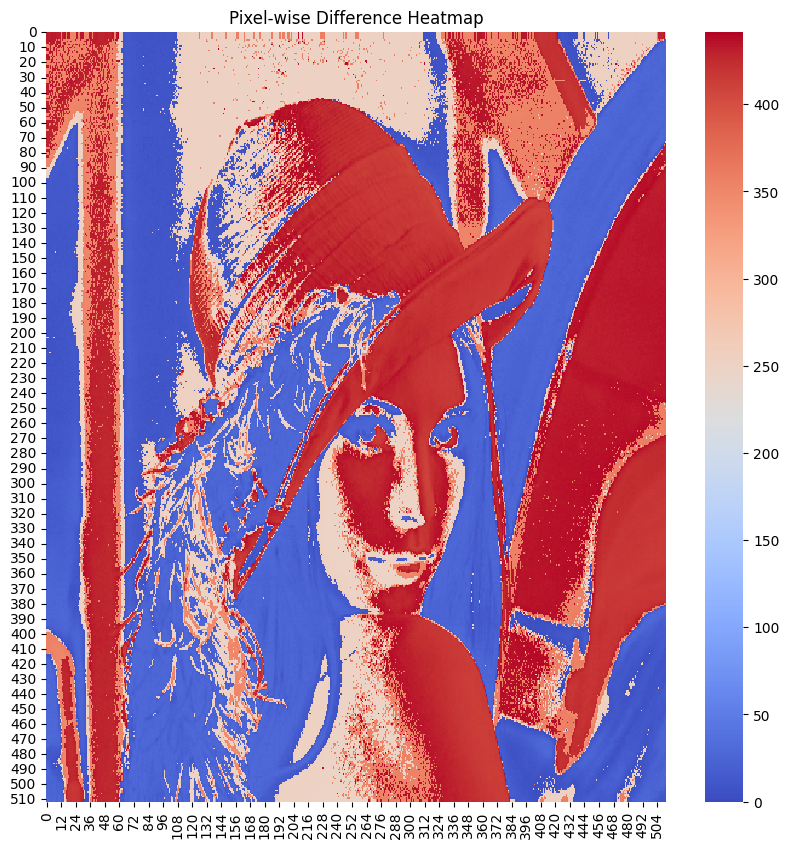

In [7]:
# Incarcam imaginea
image_path = "lena.png"

# Extragem numele
image_name = image_path.split(".")[0]

# Citim imaginea originala
original_image = cv2.imread(image_path)

# Aplicam corectia de culoare
corrected_image = color_correction(original_image)

# Before and after

# Factori - fx = 1, fy = 1 pentru 512 x 512
#           fx = 0.5, fy = 0.5 pentru 1024 x 1024
#           fx = 0.25, fy = 0.25 pentru 2048 x 2048
#           fx = 0.125, fy = 0.125 pentru 4096 x 4096

original_image = cv2.resize(original_image, None, fx=1, fy=1)
cv2.imshow("Original Image", original_image)
corrected_image = cv2.resize(corrected_image, None, fx=1, fy=1)
cv2.imshow("Color Corrected Image", corrected_image)
# Salvam imaginea corectata
cv2.imwrite(image_name + "_corrected.jpg", corrected_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Histogramele - before and after; pentru a vizualiza rezultatul cantitativ al corectiei
histograms(original_image, corrected_image)

# Histogramele pe componente
component_histograms(original_image, "Original")
component_histograms(corrected_image, "Corrected")

# Heatmapul pixelilor modificati; pentru a vizualiza rezultatul calitativ al corectiei
plot_difference_heatmap(original_image, corrected_image)